<a href="https://colab.research.google.com/github/ryderwishart/biblical-machine-learning/blob/main/structured-data-insights/macula_greek_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load MACULA data

If this notebook is being run in Colab (or anywhere on a hosted cloud environment), then you will need to clone the `macula-greek` repository before proceeding.

Set the `local_or_cloud` value in the next cell to `local` if you are running this notebook locally.

In [ ]:
local_or_cloud = 'cloud'

import os
os.getcwd()

'/content'

In [ ]:
if local_or_cloud == 'cloud':
  !git clone https://github.com/Clear-Bible/macula-greek.git

Cloning into 'macula-greek'...
remote: Enumerating objects: 4575, done.
remote: Counting objects: 100% (415/415), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 4575 (delta 330), reused 409 (delta 329), pack-reused 4160
Receiving objects: 100% (4575/4575), 565.87 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (3352/3352), done.
Updating files: 100% (133/133), done.


In [ ]:
os.listdir()

['.config', 'macula-greek', 'sample_data']

## Repository structure

```bash
macula-greek/
- Nestle1904/
  - nodes/ # contains the nodes trees
  - lowfat/ # contains the lowfat trees
  - TSV/ # contains the TSV files
    - macula-greek.tsv
- examples/
  - macula.ipynb # this notebook
```

In [ ]:
!pip install pandas
import pandas as pd
# Load ../Nestle1904/TSV/macula-greek.tsv
if local_or_cloud == 'local':
  mg = pd.read_csv('../Nestle1904/TSV/macula-greek.tsv', sep='\t', header=0)
elif local_or_cloud == 'cloud':
  mg = pd.read_csv('macula-greek/Nestle1904/TSV/macula-greek.tsv', sep='\t', header=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Inspect the column headers to see what data is available for each word
for column in mg.columns:
    print(column)

xml:id
ref
role
class
type
gloss
text
after
lemma
normalized
strong
morph
person
number
gender
case
tense
voice
mood
degree
domain
ln
frame
subjref
referent


## Preprocess the data

In [ ]:
# Extract book, chapter, and verse into separate columns
mg[['book', 'chapter', 'verse']] = mg['ref'].str.extract(r'(\d?[A-Z]+)\s(\d+):(\d+)')

# Add columns for book + chapter, and book + chapter + verse for easier grouping
mg['book_chapter'] = mg['book'] + ' ' + mg['chapter'].astype(str)
mg['book_chapter_verse'] = mg['book_chapter'] + ':' + mg['verse'].astype(str)

# Display the updated data frame
mg.head()


,xml:id,ref,role,class,type,gloss,text,after,lemma,normalized,...,domain,ln,frame,subjref,referent,book,chapter,verse,book_chapter,book_chapter_verse
0,n40001001001,MAT 1:1!1,NaN,noun,common,[The] book,Βίβλος,,βίβλος,Βίβλος,...,033005,33.38,NaN,NaN,NaN,MAT,1,1,MAT 1,MAT 1:1
1,n40001001002,MAT 1:1!2,NaN,noun,common,of [the] genealogy,γενέσεως,,γένεσις,γενέσεως,...,010002 033003,10.24 33.19,NaN,NaN,NaN,MAT,1,1,MAT 1,MAT 1:1
2,n40001001003,MAT 1:1!3,NaN,noun,proper,of Jesus,Ἰησοῦ,,Ἰησοῦς,Ἰησοῦ,...,093001,93.169a,NaN,NaN,NaN,MAT,1,1,MAT 1,MAT 1:1
3,n40001001004,MAT 1:1!4,NaN,noun,proper,Christ,Χριστοῦ,,Χριστός,Χριστοῦ,...,093001,93.387,NaN,NaN,NaN,MAT,1,1,MAT 1,MAT 1:1
4,n40001001005,MAT 1:1!5,NaN,noun,common,son,υἱοῦ,,υἱός,υἱοῦ,...,010002,10.30,NaN,NaN,NaN,MAT,1,1,MAT 1,MAT 1:1


Now that we have the book, chapter, and verse, let's group the data by book, and generate a list of unique Louw-Nida values for each book.

In [ ]:
import numpy as np

mg_word_count = mg.groupby('book').size()

# Create an array of the unique Louw-Nida domain values for each book
mg_unique_ln = mg.groupby('book')['ln'].unique()

# Print some example results
print('Word counts:\n', mg_word_count[0:5])
print('\nUnique Louw-Nida domains:\n', mg_unique_ln[0:5])

Word counts:
 book
1CO    6820
1JN    2136
1PE    1676
1TH    1473
1TI    1588
dtype: int64

Unique Louw-Nida domains:
 book
1CO    [93.294a, 33.314, 53.74, 93.387, 93.169a, 89.7...
1JN    [92.27, 13.69, 67.131, 67.65, nan, 24.52, 24.1...
1PE    [93.296, 53.74, 93.169a, 93.387, 30.93, 11.77,...
1TH    [93.294a, nan, 93.340, 93.361, 92.24, 11.32, 9...
1TI    [93.294a, 53.74, 93.387, 93.169a, nan, 33.326,...
Name: ln, dtype: object


Let's combine these two data sets into a single data frame so we can plot the data.

In [ ]:
# Turn both of the series into data frames
words = mg_word_count.to_frame().rename(columns={0: 'word_count'})
domains = mg_unique_ln.to_frame().rename(columns={0: 'ln'})

# Merge the two data frames, and add a column for the number of unique ln values
mg_books = pd.merge(words, domains, on='book')

mg_books['ln_count'] = mg_books['ln'].apply(lambda x: len(x))

mg_books.head()

,word_count,ln,ln_count
book,,,
1CO,6820,"[93.294a, 33.314, 53.74, 93.387, 93.169a, 89.7...",1308
1JN,2136,"[92.27, 13.69, 67.131, 67.65, nan, 24.52, 24.1...",327
1PE,1676,"[93.296, 53.74, 93.169a, 93.387, 30.93, 11.77,...",619
1TH,1473,"[93.294a, nan, 93.340, 93.361, 92.24, 11.32, 9...",468
1TI,1588,"[93.294a, 53.74, 93.387, 93.169a, nan, 33.326,...",537


In [ ]:
# group by verse
# group by domain
# find books with the most proper nouns

In [ ]:
!pip install matplotlib 
from matplotlib import pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


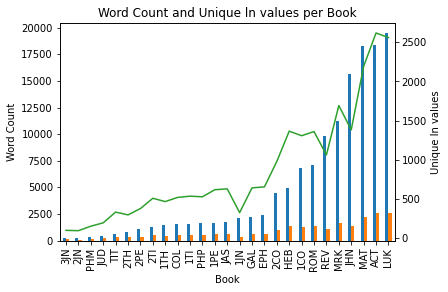

In [ ]:
# plot data
ax = mg_books.sort_values('word_count').plot(kind='bar', legend=False)
ax2 = ax.twinx() # create a second y-axis
mg_books.sort_values('word_count')['ln_count'].plot(kind='line', color='C2', ax=ax2, legend=False)

# format plot
ax.set_ylabel('Word Count')
ax2.set_ylabel('Unique ln values')
ax.set_xlabel('Book')
ax.set_title('Word Count and Unique ln values per Book')

plt.show()

Text(0.5, 1.0, 'Rate of unique domains per word')

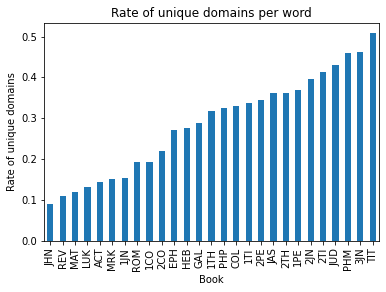

In [ ]:
# Find the books with the most unique ln values per word
mg_books['ln_rate'] = mg_books['ln_count'] / mg_books['word_count']

# Plot the ln_rate ('Semantic Density') for each book
ax = mg_books.sort_values('ln_rate').plot(kind='bar', y='ln_rate', legend=False)
ax.set_ylabel('Rate of unique domains')
ax.set_xlabel('Book')
ax.set_title('Rate of unique domains per word')

In [ ]:
mg_books.sort_values('ln_rate').head()

,word_count,ln,ln_count,ln_rate
book,,,,
JHN,15643,"[67.33, 67.65, 13.69, 92.24, 33.100, 89.93, 85...",1383,0.088410
REV,9832,"[28.38, 93.169a, 93.387, nan, 92.24, 12.1, 28....",1063,0.108116
MAT,18299,"[33.38, 10.24 33.19, 93.169a, 93.387, 10.30, 9...",2192,0.119788
LUK,19456,"[89.32, 59.1, 68.59, 62.3, 33.11, 90.24, 92.24...",2560,0.131579
ACT,18393,"[92.24, 91.6, 60.46, 33.51, 90.45, 90.24, 59.2...",2618,0.142337


While that is interesting data, it is overly sensitive to the length of each book. Let's do the same breakdown, finding the rate of unique Louw-Nida domains per word, but let's group the data by book *and* chapter instead.

In [ ]:
# Group by book_chapter column
mg_word_count = mg.groupby('book_chapter').size()

# Create an array of the unique Louw-Nida domain values for each book
mg_unique_ln = mg.groupby('book_chapter')['ln'].unique()

# Turn both of the series into data frames
words = mg_word_count.to_frame().rename(columns={0: 'word_count'})
domains = mg_unique_ln.to_frame().rename(columns={0: 'ln'})

# Merge the two data frames, and add a column for the number of unique ln values
mg_chapters = pd.merge(words, domains, on='book_chapter')

mg_chapters['ln_count'] = mg_chapters['ln'].apply(lambda x: len(x))

mg_chapters.head()

,word_count,ln,ln_count
book_chapter,,,
1CO 1,496,"[93.294a, 33.314, 53.74, 93.387, 93.169a, 89.7...",192
1CO 10,463,"[69.3, 25.1, 91.1, 92.7, 28.13 32.7, 11.23, 90...",204
1CO 11,531,"[41.45, 92.1, 13.3, 64.14, 89.92 92.1, 93.387,...",204
1CO 12,470,"[89.6, nan, 92.24, 12.21, 11.23, 69.3, 25.1, 9...",173
1CO 13,197,"[89.67, 92.24, 33.2, 9.1, 33.70, 89.92, 12.28,...",93


Text(0.5, 1.0, 'Rate of unique domains per word')

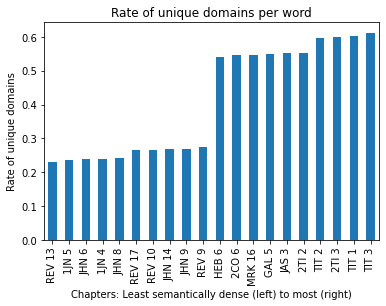

In [ ]:
# Find the chapters with the most unique ln values per word
mg_chapters['ln_rate'] = mg_chapters['ln_count'] / mg_chapters['word_count']

# Let's get the top and bottom 10 chapters based on ln_rate
sorted_chs = mg_chapters.sort_values('ln_rate', ascending=False)
top_chapters = sorted_chs.head(10)
bottom_chapters = sorted_chs.tail(10)
# Merge the top and bottom chapters into a single data frame
top_bottom_chapters = pd.concat([top_chapters, bottom_chapters])

# Plot the ln_rate ('Semantic Density') for each chapter
ax = top_bottom_chapters.sort_values('ln_rate').plot(kind='bar', y='ln_rate', legend=False)
ax.set_ylabel('Rate of unique domains')
ax.set_xlabel('Chapters: Least semantically dense (left) to most (right)')
ax.set_title('Rate of unique domains per word')

Looks like the age-old advice to "start with John" (or perhaps Johannine writings) is still good advice.

Now let's imagine we have begun a new alignment task. We want to build up a tiny corpus of paired sentences for downstream NLP tasks, and we started with the chapters that had the most bang for our buck. Now we have several chapters complete. (e.g., Revelation 13, 1 John 4-5, John 6, 8)

As we move forward with alignment, we could move on to the next chapters that give us the most bang for our buck, but we could also move on to the chapters that are most similar to the chapters we have already aligned, since this would allow us to leverage the work we have already done and get more examples for less work.

One way to assess similarity between chapters would be to use the lemmas of the words in the chapter. One problem with this approach, however, is that it does not capture contextually sensitive information. For example, the word "beast" in the book of Revelation is very different from the word "beast" in Jesus's temptation in Mark 1:13. We would probably not consider those chapters to be particularly similar despite the presence of the same lemma.

Let's compare the number of unique lemmas with the number of unique semantic domains in each chapter.

In [ ]:
mg_chapters.head()

,word_count,ln,ln_count,ln_rate
book_chapter,,,,
1CO 1,496,"[93.294a, 33.314, 53.74, 93.387, 93.169a, 89.7...",192,0.387097
1CO 10,463,"[69.3, 25.1, 91.1, 92.7, 28.13 32.7, 11.23, 90...",204,0.440605
1CO 11,531,"[41.45, 92.1, 13.3, 64.14, 89.92 92.1, 93.387,...",204,0.384181
1CO 12,470,"[89.6, nan, 92.24, 12.21, 11.23, 69.3, 25.1, 9...",173,0.368085
1CO 13,197,"[89.67, 92.24, 33.2, 9.1, 33.70, 89.92, 12.28,...",93,0.472081


In [ ]:
# Find the number of unique lemmas in each chapter by adding a new column 
# based on the unique lemmas in the original mg data frame
mg_chapters['lemma_count'] = mg.groupby('book_chapter')['lemma'].unique().apply(lambda x: len(x))
mg_chapters['lemmas'] = mg.groupby('book_chapter')['lemma'].unique()
mg_chapters['lemma_rate'] = mg_chapters['lemma_count'] / mg_chapters['word_count']

Now let's check if unique lemmas correlate with unique semantic domains.

Text(0.5, 1.0, 'Correlation between Unique Lemma Rate and Unique Domain Rate')

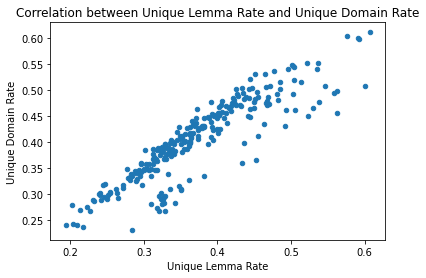

In [ ]:
# Check the correlation between lemma_rate and ln_rate, and plot the results
ax = mg_chapters.plot(kind='scatter', x='lemma_rate', y='ln_rate')
ax.set_xlabel('Unique Lemma Rate')
ax.set_ylabel('Unique Domain Rate')
ax.set_title('Correlation between Unique Lemma Rate and Unique Domain Rate')


Unique lemmas and unique semantic domains are definitely correlated. But we can also see that there is a significant amount of variation here.

In [ ]:
# What are the bottom 5 chapters with the lowest lemma_rate?
mg_chapters.sort_values('lemma_rate', ascending=True).head()

,word_count,ln,ln_count,ln_rate,lemma_count,lemmas,lemma_rate
book_chapter,,,,,,,
JHN 6,1238,"[67.48, 92.29, 15.37, 92.24, 93.169a, 83.43, 1...",296,0.239095,240,"[μετά, οὗτος, ἀπέρχομαι, ὁ, Ἰησοῦς, πέραν, θάλ...",0.193861
JHN 17,498,"[92.29, 33.70, 93.169a, 89.87, 24.34, 92.24, 8...",139,0.279116,101,"[οὗτος, λαλέω, Ἰησοῦς, καί, ἐπαίρω, ὁ, ὀφθαλμό...",0.202811
JHN 8,1087,"[93.169a, 89.124, 15.34, 84.16, 92.24, 1.46, 3...",262,0.241030,222,"[Ἰησοῦς, δέ, πορεύομαι, εἰς, ὁ, ὄρος, ἐλαία, ὄ...",0.204232
1JN 4,449,"[25.45, nan, 59.23, 12.18 12.33, 31.35, 89.125...",108,0.240535,94,"[ἀγαπητός, μή, πᾶς, πνεῦμα, πιστεύω, ἀλλά, δοκ...",0.209354
JHN 9,691,"[91.1, 15.15, 24.1, 9.24, 24.38, 67.131, 23.46...",186,0.269175,147,"[καί, παράγω, ὁράω, ἄνθρωπος, τυφλός, ἐκ, γενε...",0.212735


Now let's one-hot encode the semantic domains by chapter, and then do a simple cosine similarity between the chapters based on semantic domains. This next block can take around 30 seconds on Colab to run. 

In [ ]:
# Get all the unique domains in the MACULA Greek data set
all_unique_domains = mg['ln'].unique()

# Create a one-hot encoding for each chapter's domains
mg_chapters['one_hot_domains'] = mg_chapters['ln'].apply(lambda x: [1 if domain in x else 0 for domain in all_unique_domains])

## Cluster the chapters based on semantic domain similarity.

In [ ]:
# Identify every chapter's similarity to every other chapter by comparing
# the one-hot encodings of their domains using the cosine similarity metric

!pip install sklearn
from sklearn.metrics.pairwise import cosine_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=d8cb4f1a97d6679ad77373a66bf44758dec27c69067262d7c0571c9ae4e6a8bc
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [ ]:
# Create a new data frame with the cosine similarity values
chapter_sims = pd.DataFrame(cosine_similarity(mg_chapters['one_hot_domains'].tolist()), index=mg_chapters.index, columns=mg_chapters.index)

# Let's also normalize these similarities on a 0–100 scale:

# Find the minimum and maximum values
min_val = chapter_sims.min().min() # the minimum value of all the minimum column values
max_val = chapter_sims.max().max() # same for maximum
print(min_val, max_val)

# Normalize the data frame
chapter_sims_norm = chapter_sims.applymap(lambda x: ((x - min_val) / (max_val - min_val)) * 100)

chapter_sims_norm.head()


0.013565948792607994 1.0000000000000036


book_chapter,1CO 1,1CO 10,1CO 11,1CO 12,1CO 13,1CO 14,1CO 15,1CO 16,1CO 2,1CO 3,...,ROM 3,ROM 4,ROM 5,ROM 6,ROM 7,ROM 8,ROM 9,TIT 1,TIT 2,TIT 3
book_chapter,,,,,,,,,,,,,,,,,,,,,
1CO 1,100.000000,28.485122,27.455454,26.030841,12.390308,22.045578,27.037540,24.061111,29.953573,30.521803,...,23.299472,22.794547,22.991142,21.436854,23.075601,24.167412,21.210532,14.795619,11.100846,15.161979
1CO 10,28.485122,100.000000,29.586648,25.750995,14.944468,27.968889,24.031820,21.054837,24.389119,25.399683,...,25.160617,24.537134,21.669102,25.054920,27.085340,22.448025,23.795705,11.986584,10.054159,11.580941
1CO 11,27.455454,29.586648,100.000000,26.836045,15.686274,28.442182,31.352502,26.101606,27.692244,27.184679,...,23.079372,23.920172,25.214387,24.440265,25.306553,26.259750,23.795705,14.891331,12.071114,10.963980
1CO 12,26.030841,25.750995,26.836045,100.000000,16.354249,28.961251,26.226612,23.601655,26.614777,26.419843,...,25.191887,22.754031,24.301715,21.328323,25.034866,22.435501,24.450914,15.034252,13.232679,17.391968
1CO 13,12.390308,14.944468,15.686274,16.354249,100.000000,21.825270,16.535538,16.116947,21.195025,20.720563,...,16.401200,16.037436,15.301353,16.885373,17.120675,16.318732,14.550059,7.254383,9.610296,11.455150


Now, let's return to our imagined scenario, where we have Revelation 13, 1 John 4-5, and John 6 and 8 aligned, and we want to move on to the next-most-similar chapters.

In [ ]:
!pip install plotly
!pip install networkx
import plotly.graph_objects as go
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Let's set the threshold for what counts as "similar" chapters in semantic domains
threshold = 0 # percentage value

# Create a new data frame subset based on your selected book

# Instantiate a graph
graph = nx.Graph()

In [ ]:
### Populate graph nodes

# Let's decide which chapter we want to query
ch_query = 'REV 13'

# Add nodes for each book in the query
for ch in chapter_sims_norm.index:
    if ch in ch_query:
        graph.add_node(ch)

# ### Populate graph edges

n = 3  # number of top-n values to keep

# Create a dictionary to store the top-n values for each node
top_n = {ch: [] for ch in chapter_sims_norm.index}

# Loop through the matrix and keep track of the top-n values for each node
for i, ch1 in enumerate(chapter_sims_norm.index):
    for j, ch2 in enumerate(chapter_sims_norm.columns):
        if not i == j:
            similarity = chapter_sims_norm.loc[ch1, ch2]
            if similarity >= threshold:
                top_n[ch1].append((similarity, ch2))
                top_n[ch2].append((similarity, ch1))

# Sort the top-n values for each node and keep only the top-n values
for ch in top_n:
    top_n[ch] = sorted(top_n[ch], reverse=True)[:n]

# Add edges for the top-n values for each node
for ch in top_n:
    for similarity, ch2 in top_n[ch]:
        graph.add_edge(ch, ch2, weight=similarity)


In [ ]:
for ch, sim_list in top_n.items():
    print(sorted(sim_list, key=lambda x: x[1]))
    break
    top_n[ch] = sim_list[:n]

[(30.521803423673443, '1CO 3'), (30.521803423673443, '1CO 3'), (30.38733767338671, '2CO 1')]


In [ ]:
# Draw edges on graph
positions = nx.spring_layout(graph)

edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Draw nodes on graph

node_x = []
node_y = []
for node in graph.nodes():
    x, y = positions[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=20,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
# Color nodes

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(graph.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0] + ': # of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
# Display the graph

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [ ]:
# pos = nx.spring_layout(graph)
# nx.draw_networkx_nodes(graph, pos)
# nx.draw_networkx_edges(graph, pos)
# nx.draw_networkx_labels(graph, pos)

In [ ]:
del graph